In [1]:
# necessary libraries
using Plots
using LinearAlgebra

In [2]:
# Rosenbrock function
f_rb_quad(x, y) = (1-x)^2 + 100*(4y - x^2)^2 #quadratic form
f_rb(x) = (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2 # vector form
∇f_rb(x) = [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]

∇f_rb (generic function with 1 method)

In [3]:
function rosenplot(f; xlims=(-3,2), ylims=(-0.5,2))
    x = xlims[1]:0.01:xlims[2]
    y = ylims[1]:0.01:ylims[2]
    contour(x, y, f,
        size=(800, 250),
        framestyle=:box,
        color = cgrad(:viridis),
        levels=[2,10,50,200,500],
        clims=(0, 601),
        legend=(loc=:outertopright),
        xlims=xlims,
        ylims=ylims,
    )
end

rosenplot (generic function with 1 method)

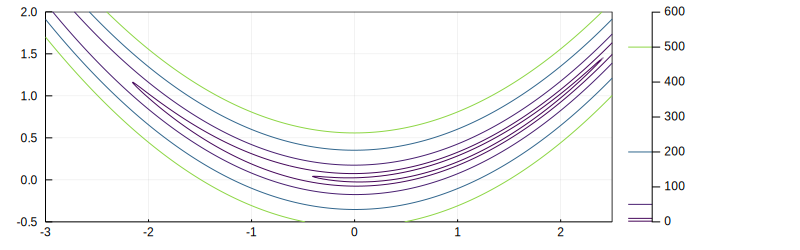

In [4]:
base = rosenplot(f_rb_quad, xlims=(-3, 2.5), ylims=(-0.5, 2))

# Momentum 

In [5]:
abstract type DescentMethod end

mutable struct Momentum <: DescentMethod
    x # positions
    α # learning rate
    β # momentum decay
    v # momentum
end

function step!(M::Momentum, f, ∇f)
    α, β, v, g = M.α, M.β, M.v, ∇f(M.x)
    M.v = β*M.v - M.α*g
    M.x += M.v
end

function optimize(M::Momentum, f, ∇f; f_tol=1e-10, g_tol=1e-2, max_iter=1000)
    
    xs = copy(M.x)'
    
    for i in 1:max_iter
        x_prev = M.x
        step!(M::Momentum, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 1 method)

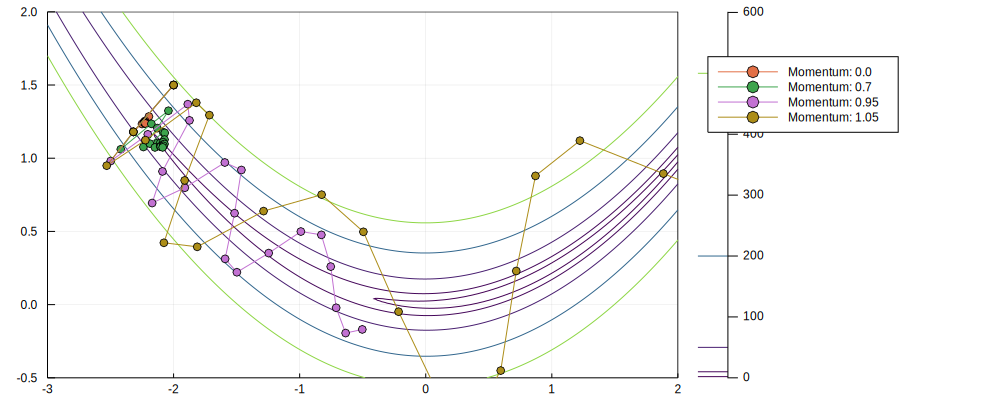

In [7]:
x0 = [-2, 1.5]
N_iter = 20

base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-0.5, 2))

for β in [0, 0.70, 0.95, 1.05]
    M = Momentum(x0, 2e-4, β, zeros(length(x0)))
    xs = optimize(M, f_rb, ∇f_rb, max_iter=N_iter)
    plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("Momentum: ", M.β) )
end
plot!(size=(1000, 400))

base

# Nesterov Momentum 

In [6]:
mutable struct NesterovMomentum <: DescentMethod
    x # positions
    α # learning rate
    β # momentum decay
    v # momentum
end

function step!(M::NesterovMomentum, f, ∇f)   
    α, β, v = M.α, M.β, M.v
    M.v = β*M.v - α*∇f(M.x + β*v)
    M.x += M.v
end

function optimize(M::NesterovMomentum, f, ∇f; f_tol=1e-10, g_tol=1e-2, max_iter=1000)
    
    xs = copy(M.x)'
    for i in 1:max_iter
        x_prev = M.x
        step!(M::NesterovMomentum, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 2 methods)

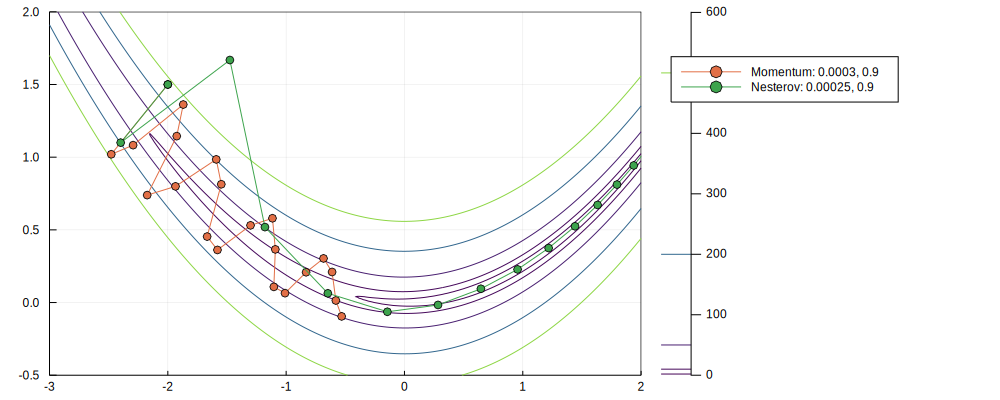

In [9]:
x0 = [-2, 1.5]
#x0 = [-1.7098472161941083, 0.7221094899528373]
N_iter = 20

base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-0.5, 2))

for β in [0.9]
    M = Momentum(x0, 3e-4, β, zeros(length(x0)))
    xs = optimize(M, f_rb, ∇f_rb, max_iter=N_iter)
    plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("Momentum: ", M.α, ", ", M.β) )
end

M1 = NesterovMomentum(x0, 2.5e-4, 0.9, zeros(length(x0)))
xs = optimize(M1, f_rb, ∇f_rb, max_iter=N_iter)
plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("Nesterov: ", M1.α, ", ", M1.β, ) )
plot!(size=(1000, 400))

base


# Adam

In [10]:
mutable struct Adam <: DescentMethod
    x # positions
    α # learning rate
    γv # decay
    γs # decay
    ϵ # small value
    k # step counter
    v # 1st moment estimate
    s # 2nd moment estimate
end

function step!(M::Adam, f, ∇f)
    α, γv, γs, ϵ, k = M.α, M.γv, M.γs, M.ϵ, M.k
    s, v, g = M.s, M.v, ∇f(M.x)
    M.v = γv*v + (1-γv)*g
    M.s = γs*s + (1-γs)*g.*g
    M.k += 1
    v_hat = M.v ./ (1 - γv^k)
    s_hat = M.s ./ (1 - γs^k)
    M.x -= α*v_hat ./ (sqrt.(s_hat) .+ ϵ)
    #@show(α, M.v, M.s, γv, γs, v_hat, s_hat, k, M.x)
    
    
end

function optimize(M::Adam, f, ∇f; f_tol=1e-10, g_tol=1e-4, max_iter=1000)
    xs = copy(M.x)'
    for i in 1:max_iter
        x_prev = M.x
        step!(M::Adam, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 3 methods)

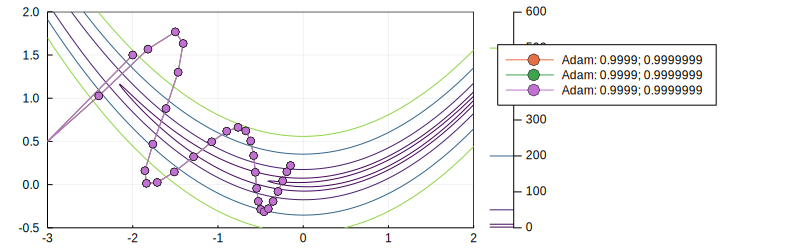

In [12]:
x0 = [-2, 1.5]
N_iter = 30
base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-0.5, 2))

for r in [0.7, 0.8, 0.999]
    M = Adam(x0, 1.0-1.0e-4, 0.9, 1-1.0e-7, 1.0e-8, 1, ones(length(x0)), zeros(length(x0)))
    #M = Adam(x0, 1e-0, 0.9, r, 1e-8, 1, zeros(length(x0)), zeros(length(x0)))
    xs = optimize(M, f_rb, ∇f_rb, max_iter=N_iter)
    plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("Adam: ", M.α, "; ", M.γs) )
end
base



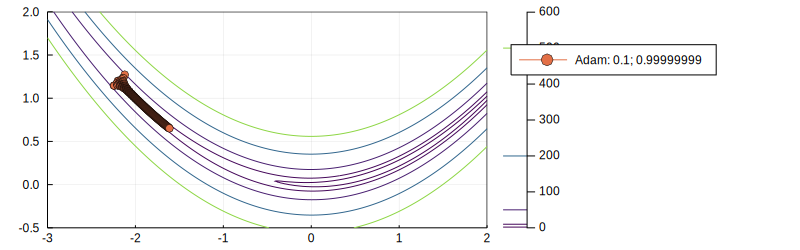

In [29]:
#x0 = [-1.8, 0.9]
x0 = [-2.2, 1.2]
N_iter = 200
base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-0.5, 2))

M = Adam(x0, 1e-1, 0.9, 1-1e-8, 1.0e-8, 1, ones(length(x0)), zeros(length(x0)))
xs = optimize(M, f_rb, ∇f_rb, max_iter=N_iter)
plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("Adam: ", M.α, "; ", M.γs) )
base

In [19]:
println(xs[4,:])

[-1.6942662656180822, 0.5528538487254386]
